In [12]:
import torch
from torchvision.utils import save_image
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from VAE import VAE
from GAN_steering.SAE import SparseAutoencoder
import os
import tqdm

In [13]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'

# Load models
vae_path = '/Users/spra/Desktop/Personal Projects/CV_final_project/vae_epoch_15.pt'
sae_path = '/Users/spra/Desktop/Personal Projects/CV_final_project/sae_epoch_25.pt'
vae = VAE(device=DEVICE, latent_dim=128).to(DEVICE)
sae = SparseAutoencoder(latent_dim=128, hidden_dim=512, device=DEVICE).to(DEVICE)
vae.load_state_dict(torch.load(vae_path, map_location=DEVICE))
sae.load_state_dict(torch.load(sae_path, map_location=DEVICE))
vae.eval()
sae.eval()

SparseAutoencoder(
  (encoder): Linear(in_features=128, out_features=512, bias=False)
  (relu): ReLU()
)

In [14]:
sae.encoder.weight.shape

torch.Size([512, 128])

In [15]:
def get_dataloader():
    transform = transforms.Compose([
        transforms.Resize(64),
        transforms.CenterCrop(64),
        transforms.ToTensor(),
    ])
    dataset = datasets.ImageFolder(root='/Users/spra/Desktop/Personal Projects/CV_final_project/CelebA/celeba', transform=transform)
    dataloader = DataLoader(dataset, batch_size=64, shuffle=True)
    return dataloader

In [16]:
test_dataloader = get_dataloader()

In [17]:
vae.eval()
sae.eval()

# # Get a batch of test images
# test_batch, _ = next(iter(test_dataloader))
# test_batch = test_batch[:num_samples].to(DEVICE)

# Get VAE latents
with torch.no_grad():
    average_activations = torch.zeros((512,)).to(DEVICE)
    count = 0
    for batch in tqdm.tqdm(test_dataloader):
        batch = batch[0].to(DEVICE)
        mu, _ = vae.encoder(batch)
        z = sae.encoder(mu)  # shape: [batch, hidden_dim]
        # Compute mean activation for each feature
        activations = z.abs().mean(dim=0)  # shape: [hidden_dim]
        average_activations = (average_activations * count + activations)/(count + 1)
        count += 1
    print(count)
    # Get indices of top 10 most active features
    topk = torch.topk(average_activations, 10).indices.tolist()

100%|██████████| 40520/40520 [02:21<00:00, 287.27it/s]

40520


In [27]:
import einops
import matplotlib.pyplot as plt
import numpy as np
def display_img(img, h, w):
    ''' 
    Takes an image of dimension (batch_dim, channels, height, width), and prints them in a h x w grid.
    '''
    if img.device.type != 'cpu':
        img = img.cpu()
    reshaped = einops.rearrange(img, 'b c h w -> b h w c').cpu().numpy()
    if h == 1 and w == 1:
        plt.imshow(reshaped[0])
        plt.show()
        return None
    fig, ax = plt.subplots(h, w, figsize=(10, 10))
    # Ensure ax is always 2D for consistent indexing
    if h == 1:
        ax = np.expand_dims(ax, axis=0)
    if w == 1:
        ax = np.expand_dims(ax, axis=1)
    for row in range(h):
        for col in range(w):
            to_show = reshaped[w * row + col]
            ax[row, col].imshow(to_show)
            ax[row, col].axis('off')
    plt.tight_layout()
    plt.show()

In [18]:
topk

[383, 186, 447, 120, 443, 479, 63, 228, 124, 55]

In [19]:
print("Top 10 most active features:", topk)

Top 10 most active features: [383, 186, 447, 120, 443, 479, 63, 228, 124, 55]


In [ ]:
# 447 is pose
# 479 is dark hair

In [120]:
feature_idx = 228

In [121]:
variations = []
for scale in [-10.0, -4.0, 0.0, 5.0, 10.0]:
    latent = torch.randn((5, 128)).to(DEVICE)
    sparse_rep = sae.encoder(latent)
    sparse_rep = einops.repeat(average_activations, 'n -> b n', b = 5).to(DEVICE)
    internal = torch.zeros((512, )).to(DEVICE)
    internal[feature_idx] = 1
    sparse_rep = sparse_rep + scale * internal
    latent = sae.decode(sparse_rep)
    recon = vae.decoder(latent)
    print(recon.shape)
    variations.append(recon)
variations = torch.stack(variations, dim=0)
variations = einops.rearrange(variations, 'b1 b2 c h w -> (b2 b1) c h w')

torch.Size([5, 3, 64, 64])
torch.Size([5, 3, 64, 64])
torch.Size([5, 3, 64, 64])
torch.Size([5, 3, 64, 64])
torch.Size([5, 3, 64, 64])


In [122]:
variations = variations.detach().clone()

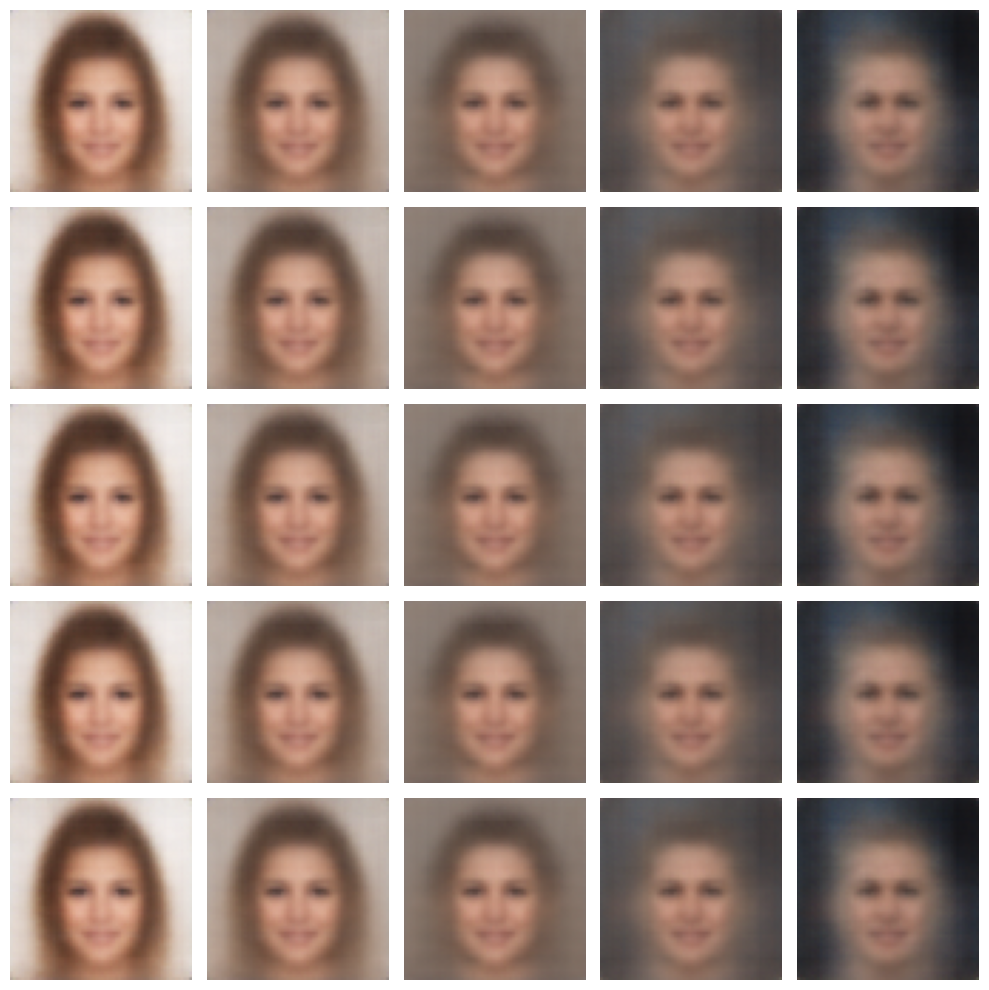

In [123]:
display_img(variations, h = 5, w = 5)